In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import prettypyplot as pplt

import pymbar
from pymbar import timeseries

import os
import sys
import tables as tb
import mdtraj as md
import scipy.stats

upside_path = '/project/dinner/scguo/upside2'
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

import mdtraj_upside as mu
# import upside_engine as ue

In [2]:
plt.style.use("custom")
plt.style.use("muted")
pplt.load_cmaps()

In [55]:
exp_data_file = "/project/dinner/scguo/kaiB/m_dG_exp.csv"
exp_data = np.loadtxt(exp_data_file, delimiter=',', encoding='utf-8-sig')
exp_mVals = exp_data[:, 0]
exp_dGs  = exp_data[:, 1]
exp_mVal_mask = (exp_mVals != 0)
exp_dGs_mask = (exp_dGs != 0)

# ex2 residues
a_dg_file1 = '/project/dinner/aanto/kaiB/up2/dgs_al_45.csv'
a_dgs1 = np.genfromtxt(a_dg_file1, delimiter=',')
ex2_indices = a_dgs1[a_dgs1[:, -2] == 1, -1] - 1

In [194]:
exp_mVals.nonzero()

(array([ 7,  8,  9, 10, 11, 12, 13, 15, 17, 21, 22, 23, 24, 25, 26, 27, 28,
        29, 31, 32, 33, 35, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 58, 63,
        64, 65, 66, 67, 68, 73, 75, 83, 84, 85, 86, 88, 89, 90, 92, 93, 94]),)

In [31]:
color_arr = []
alpha_arr = []

for r in np.arange(0, 99):
    if r >= 8 and r <= 13:
        color='crimson'
    elif r >= 20 and r <= 34:
        color='crimson'
    elif r >= 40 and r <= 45:
        color='crimson'
    elif r >= 49 and r <= 55:
        color = 'orchid'
    elif r >= 63 and r <= 68:
        color='darkorange'
    elif r >= 72 and r <= 76:
        color='forestgreen'
    elif r >= 83 and r <= 95:
        color='mediumblue' 
    else: 
        color='slategray'
    
    if r in ex2_indices:
        alpha = 1
    else:
        alpha = 0.3
    color_arr.append(color)
    alpha_arr.append(alpha)
color_arr = np.asarray(color_arr)
alpha_arr = np.asarray(alpha_arr)

# Load data - For FS (all trans)

In [3]:
pdb_id = 'fs_almut_p71a'
start_frame = 2000 # skip first 2000 frames
work_dir = '/project/dinner/scguo/kaiB/p71a/run_0'
n_rep = 48 # replica number
input_dir = f"{work_dir}/inputs"
result_dir = f"{work_dir}/outputs"

In [4]:
Pot = []
Hb = []
Ts = []
T  = []
PS = []
for i in range(n_rep):
    j=str(i).zfill(2)
    Pot.append(np.load(f'{result_dir}/{pdb_id}.run.{j}_Energy.npy')[:,0])  
    Hb.append(np.load(f'{result_dir}/{pdb_id}.run.{j}_Hbond.npy')) 
    PS.append(np.load(f'{result_dir}/{j}_ps.npy'))
    t = np.load(f'{result_dir}/{pdb_id}.run.{j}_T.npy')
    nsize = Pot[-1].size
    Ts.append(np.zeros(nsize) + t)
    T.append(t)
    
Pot  = np.array(Pot)
Hb   = np.array(Hb)
Ts   = np.array(Ts)
T    = np.array(T)
PS   = np.array(PS)

# only the residue numbers which have experimental data
res = np.loadtxt('/project/dinner/scguo/kaiB/fs_almut.resid', dtype=int)
n_res = res.size

print(PS.shape, Pot.shape)

(48, 62196, 92) (48, 62196)


In [5]:
kB = 1.0 # upside unit
T = np.array(T)
beta = 1 / (kB * T)

cE0 = Pot[:,start_frame:]

FN = cE0[0].size
FNs = np.zeros([n_rep], np.int32) + FN
reducedPot0 = np.zeros([n_rep,n_rep,FN], np.float32)
for k in range(n_rep):
    for l in range(n_rep):
        reducedPot0[k,l] = beta[l] * cE0[k]

In [6]:
mbar0 = pymbar.MBAR(reducedPot0, FNs, verbose=True)

K (total states) = 48, total samples = 2889408
N_k = 
[60196 60196 60196 60196 60196 60196 60196 60196 60196 60196 60196 60196
 60196 60196 60196 60196 60196 60196 60196 60196 60196 60196 60196 60196
 60196 60196 60196 60196 60196 60196 60196 60196 60196 60196 60196 60196
 60196 60196 60196 60196 60196 60196 60196 60196 60196 60196 60196 60196]
There are 48 states with samples.
Initializing free energies to zero.
Initial dimensionless free energies with method zeros
f_k = 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Determining dimensionless free energies by Newton-Raphson / self-consistent iteration.
self consistent iteration gradient norm is 3.6067e+11, Newton-Raphson gradient norm is 4.5826e+11
Choosing self-consistent iteration on iteration 0
self consistent iteration gradient norm is 1.6204e+11, Newton-Raphson gradient norm is 2.4609e+11
Choosing self-consistent iteration for low

## Calculate $\Delta G_{\mathrm{HX}}$ at different temperatures (melting curves)

In [ ]:
# dGhx_T = np.zeros((T.size, n_res))
# for k in range(T.size):
#     t = T[k]
#     tt = t / 0.85 * 298. # "real" temperature in K (estimated)
    
#     # convert back to unstandardized energies (not in units of kT)
#     u_n = (cE0 / (t * kB)).flatten()
#     log_w1 = mbar0._computeUnnormalizedLogWeights(u_n)
#     # normalize weights
#     w1 = np.exp(log_w1)
#     w1 /= np.sum(w1)
    
#     # use eq. 4.8 in Adam's thesis
#     for r in range(n_res):
#         pf_i = PS[:,start_frame:,r].flatten()
#         mean_pf = np.average(pf_i, weights=w1)
#         if mean_pf == 1:
#             print(k, r)
#             dGhx_T[k, r] = 1000.
#         else:
#             dGhx_T[k, r] = 0.001987 * tt * np.log((mean_pf / (1 - mean_pf))) # units of kcal/mol

In [7]:
# np.save(f"{result_dir}/dghx.npy", dGhx_T)
dGhx_T = np.load(f"{result_dir}/dghx.npy")
print(dGhx_T.shape)

(48, 91)


In [80]:
# indices in exp dataset which have simulated values (i.e. the "true" sequence indices)
exp_and_sim_dG = res[np.nonzero(exp_dGs[res] != 0)]
# indices in sim dataset which have experimental values
sim_and_exp_dG = np.nonzero(exp_dGs[res] != 0)[0]
exp_and_sim_mVal = res[np.nonzero((exp_mVals[res] != 0))]
sim_and_exp_mVal = np.nonzero(exp_mVals[res] != 0)[0]

Text(0.5, 1.0, '$T=0.85$, $R^2=0.38$')

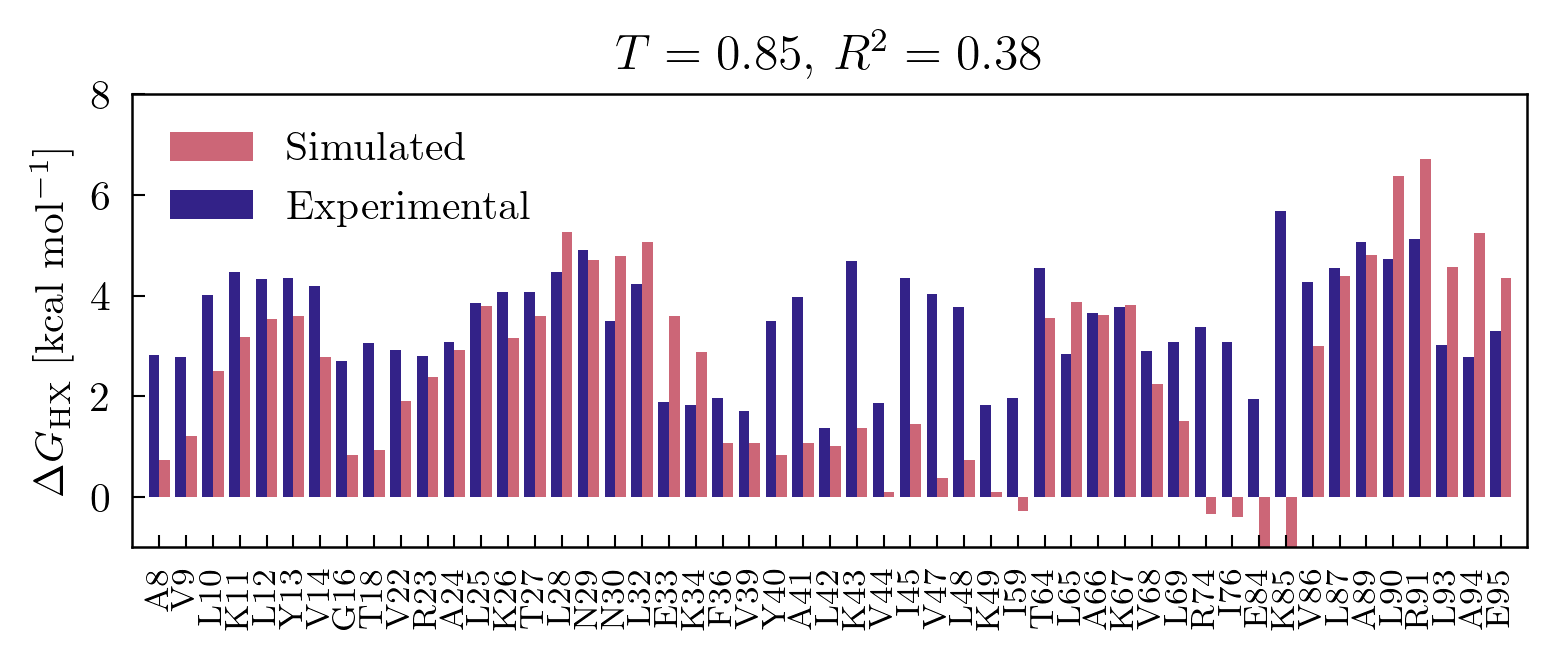

In [101]:
# plot residues
seq = "MAPLRKTAVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPAPVRRIIGDLSNREKVLIALRLLAEEIGD"
names = []
for r in exp_and_sim_dG:
    names.append(f"{seq[r]}{r + 1}")
T_ind = 15
n_data = len(exp_and_sim_dG)

fig = plt.figure(dpi=300, figsize=(6, 2))
ax = fig.gca()
plt.bar(range(n_data), dGhx_T[T_ind, sim_and_exp_dG], align='edge', width=0.4, label='Simulated')
plt.bar(range(n_data), exp_dGs[exp_and_sim_dG] / 4.184, align='edge', width=-0.4, label='Experimental')
plt.xlim([-1, n_data])
plt.ylim([-1, 8])
ax.set_ylabel('$\Delta G_{\mathrm{HX}}$ [kcal mol$^{-1}$]')
ax.set_xticks(np.arange(n_data), names, rotation=90, fontsize=8)

pplt.legend(outside=False)
r2, pval = scipy.stats.pearsonr(exp_dGs[exp_and_sim_dG] / 4.184, dGhx_T[T_ind, sim_and_exp_dG])
plt.title(f"$T={Ts[T_ind, 0]:.2f}$, $R^2={r2:.2f}$")

In [102]:
for T_ind in range(48):    
    r2, pval = scipy.stats.pearsonr(exp_dGs[exp_and_sim_dG] / 4.184, dGhx_T[T_ind, sim_and_exp_dG])
    print(r2, pval)

0.3732679481373366 0.006978845372139666
0.3735588822789248 0.0069314207853117555
0.3739631821006003 0.006865982464598849
0.3744934175580566 0.006780976196973973
0.37515370057717506 0.006676403040321664
0.3759367264045349 0.006554213128611639
0.37682219910527326 0.006418388174004764
0.377777321049023 0.006274636302568335
0.37875885081644844 0.006129843025016891
0.37971636670103426 0.005991409938162555
0.3805962147502517 0.005866619530556186
0.3813463171316733 0.005762029612619862
0.3819216948077066 0.005682909834537914
0.3822892473745537 0.005632866306169977
0.3824292075591755 0.005613911749611087
0.3823318762468597 0.005627087240025121
0.38199094524191574 0.005673451559834195
0.38139647917666986 0.005755093783122932
0.3805295985454937 0.005875987759390242
0.3793591028082927 0.006042738955373322
0.3778390302124724 0.006265446017046951
0.3759056775659612 0.006559020892471355
0.37347075302585847 0.006945756857811388
0.3704027151989457 0.007461189280492563
0.366470058265071 0.0081702462959

# Calculate $\Delta G_{\mathrm{HX}}$ as a function of denaturant

In [103]:
T_target = 0.875   # the T you want to use 
m_sens = 0.25  # it is the sensitivity of the denaturant.
                 # a larger value means a lower concentration 
                 # to unfold the protein
                 # 0.05 is a not bad initial guess for urea

# the number of protected residues in evergy frame
pf_frame = np.sum(PS[:, start_frame:, :], axis=2).flatten()

# [den]
den_min = 0.0
den_max = 5
den_bin = 50
den = np.linspace(den_min, den_max, den_bin+1)

# reweight to T_target
TT = T_target / 0.85 * 298
m = m_sens * -pf_frame
u_n = (cE0 / (T_target * kB)).flatten()
log_w1 = mbar0._computeUnnormalizedLogWeights(u_n)
w1 = np.exp(log_w1)
w1 /= np.sum(w1)

# dG at different [den]
dGhx_D = []
for d in den:
    # weight depends on denaturant concentration
    w = np.exp(m * d / T_target) * w1
    w /= np.sum(w)
    
    probp = np.zeros(n_res)
    for j in range(n_res):
        pf_i = PS[:, start_frame:, j].flatten()
        probp[j] = np.sum(pf_i * w)
    dGhx_D.append(TT * np.log(probp / (1. - probp)) * 0.001987)
dGhx_D = np.array(dGhx_D)

# m-value: negative of initial slope of dG vs [den] 
mValue = np.diff(dGhx_D, axis=0) / (den[0] - den[1])

In [104]:
# np.save(f"{result_dir}/dghx_den.npy", dGhx_D)
# np.save(f"{result_dir}/m_sens25.npy", mValue)
dGhx_D = np.load(f"{result_dir}/dghx_den.npy")
mValue = np.load(f"{result_dir}/m_sens25.npy")

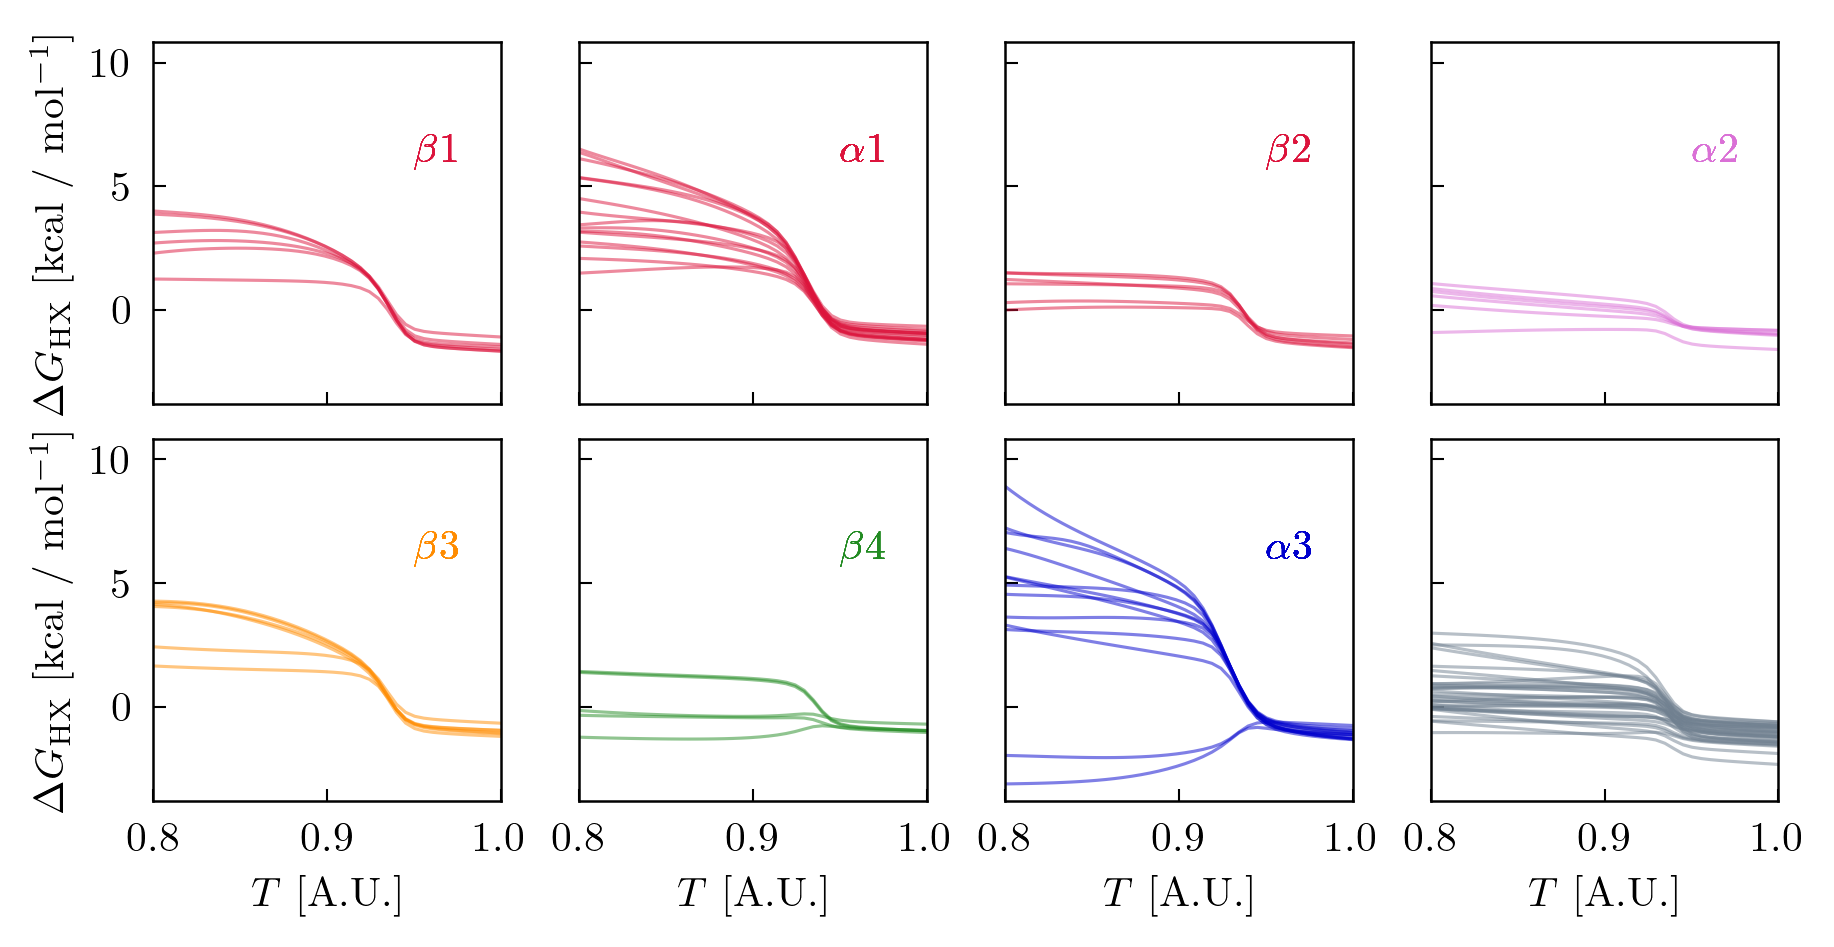

In [161]:
f, axs = plt.subplots(2, 4, figsize=(6,3), dpi=300, sharey=True, sharex=True, constrained_layout=True)

for i, (r, color) in enumerate(zip(res, color_arr[res])):
    if r >= 8 and r <= 13:
        j, k = 0, 0
        text = r'$\beta 1$'
    elif r >= 20 and r <= 34:
        j, k = 0, 1
        text = r'$\alpha 1$'
    elif r >= 40 and r <= 45:
        j, k = 0, 2
        text = r'$\beta 2$'
    elif r >= 49 and r <= 55:
        j, k = 0, 3
        text = r'$\alpha 2$'
    elif r >= 63 and r <= 68:
        j, k = 1, 0
        text = r'$\beta 3$'
    elif r >= 72 and r <= 76:
        j, k = 1, 1
        text = r'$\beta 4$'
    elif r >= 83 and r <= 95:
        j, k = 1, 2
        text = r'$\alpha 3$'
    else: 
        j, k = 1, 3
        text=''
    axs[j, k].plot(Ts[:, 0], dGhx_T[:,i], color=color, alpha=0.5)
    axs[j, k].text(0.95, 6, text, color=color)


for a in axs.flat:
    a.set_xlim([0.8, 1.0])
    a.set_xlabel('$T$ [A.U.]')
    a.set_ylabel('$\Delta G_{\mathrm{HX}}$ [kcal / mol$^{-1}$]')
    a.label_outer()

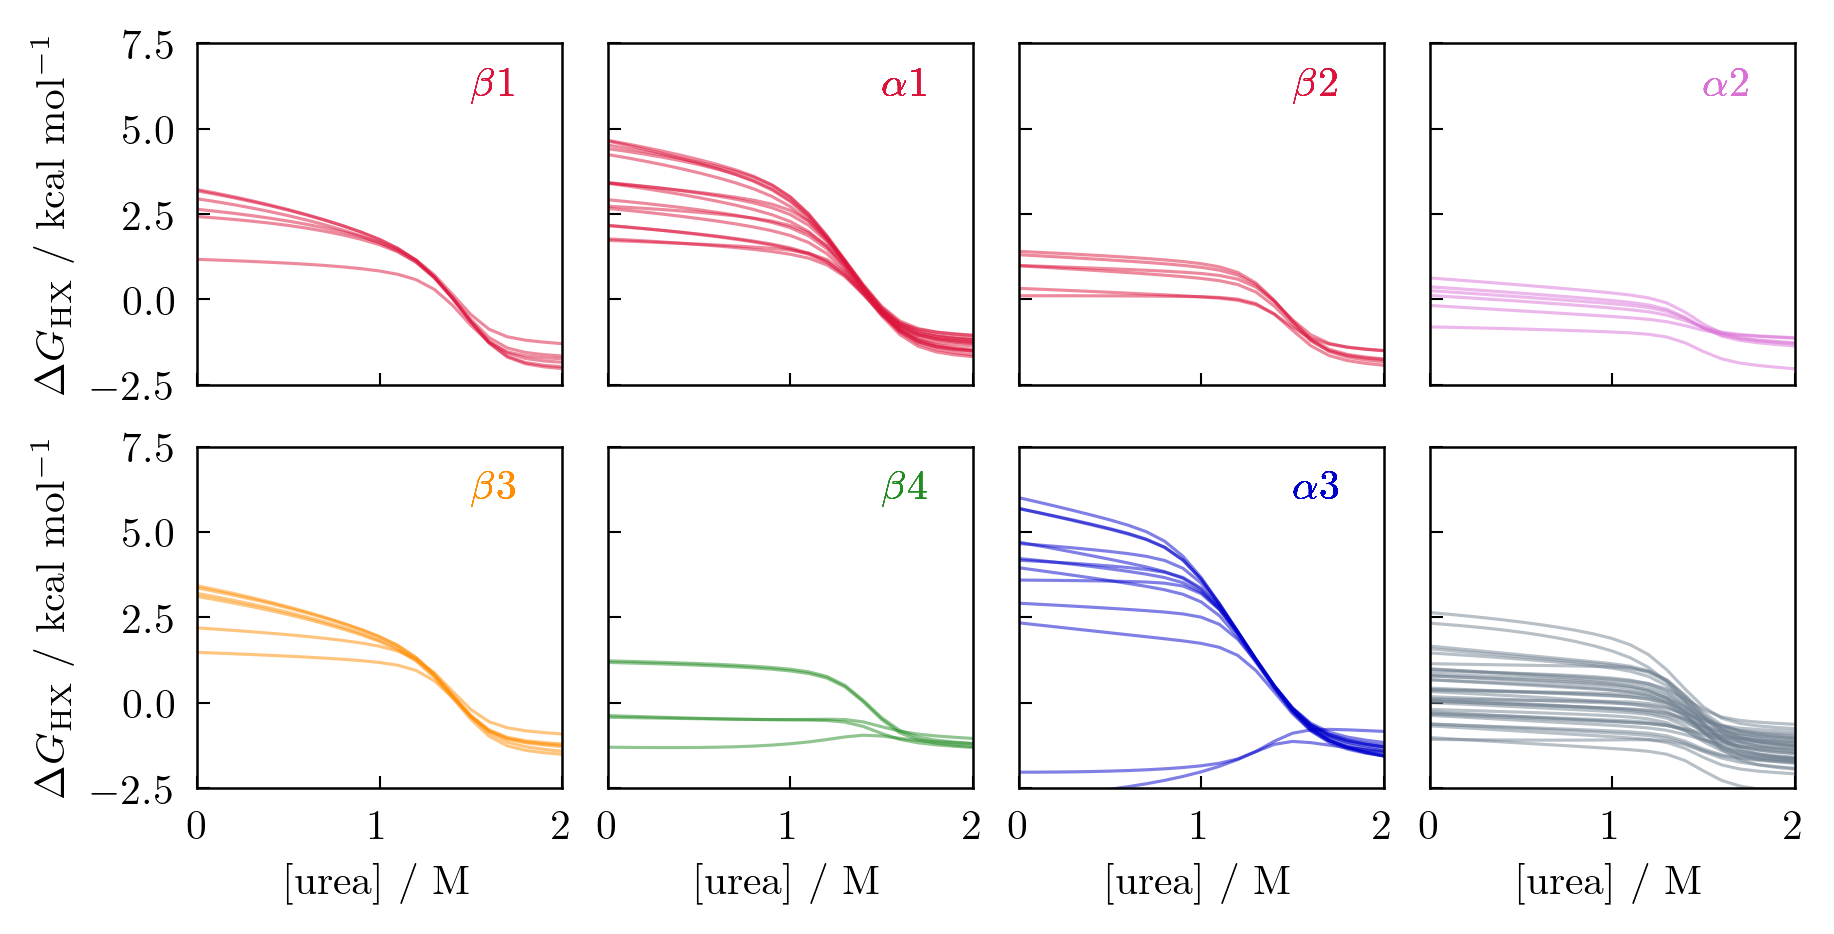

In [105]:
f, ax = plt.subplots(2, 4, figsize=(6,3), dpi=300, sharey=True, sharex=True, constrained_layout=True)

for i, (r, color) in enumerate(zip(res, color_arr[res])):
    if r >= 8 and r <= 13:
        j, k = 0, 0
        text = r'$\beta 1$'
    elif r >= 20 and r <= 34:
        j, k = 0, 1
        text = r'$\alpha 1$'
    elif r >= 40 and r <= 45:
        j, k = 0, 2
        text = r'$\beta 2$'
    elif r >= 49 and r <= 55:
        j, k = 0, 3
        text = r'$\alpha 2$'
    elif r >= 63 and r <= 68:
        j, k = 1, 0
        text = r'$\beta 3$'
    elif r >= 72 and r <= 76:
        j, k = 1, 1
        text = r'$\beta 4$'
    elif r >= 83 and r <= 95:
        j, k = 1, 2
        text = r'$\alpha 3$'
    else: 
        j, k = 1, 3
        text=''
    ax[j, k].plot(den, dGhx_D[:,i], color=color, alpha=0.5)
    ax[j, k].text(1.5, 6, text, color=color)

ax[0,0].set_xlim([0, 2])
ax[0,0].set_ylim([-2.5, 7.5])
for a in ax.flat:
    a.set_xlabel('[urea] / M')
    a.set_ylabel('$\Delta G_{\mathrm{HX}}$ / kcal mol$^{-1}$')
    a.label_outer()

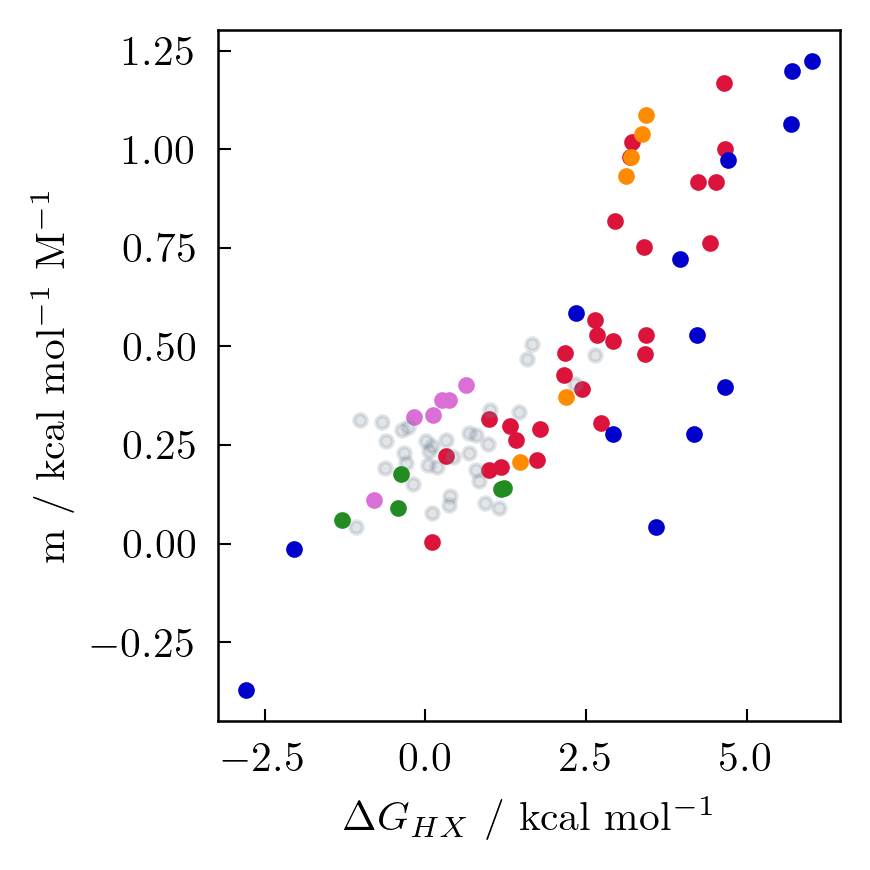

In [106]:
f1, ax1 = plt.subplots(figsize=(3,3), dpi=300)
for i, c in enumerate(color_arr[res]):
    if c == 'slategray':
        alpha = 0.2
    else:
        alpha = 1.0
    ax1.plot(dGhx_D[0,i], mValue[0,i], '.', color=c, alpha=alpha, markersize=6)
ax1.set_xlabel('$\Delta G_{HX}$ / kcal mol$^{-1}$')
ax1.set_ylabel('m / kcal mol$^{-1}$ M$^{-1}$')
f1.tight_layout()

## different sensitivity to urea

In [108]:
def den_sens(den, w1, m, PS, m_sens=0.05, T_target=0.875):
    n_res = PS.shape[2]
    
    TT = T_target / 0.85 * 298
    # dG at different [den]
    dGhx_D = []
    for d in den:
        # weight depends on denaturant concentration
        w = np.exp(m * d / T_target) * w1
        w /= np.sum(w)

        probp = np.zeros(n_res)
        for j in range(n_res):
            pf_i = PS[:, start_frame:, j].flatten()
            probp[j] = np.sum(pf_i * w)
        dGhx_D.append(TT * np.log(probp / (1. - probp)) * 0.001987)
    dGhx_D = np.array(dGhx_D)

    # m-value: negative of initial slope of dG vs [den] 
    mValue = np.diff(dGhx_D, axis=0) / (den[0] - den[1])
    
    return dGhx_D, mValue

In [109]:
T_target = 0.875   # the T you want to use 
m_sens = 0.05  # it is the sensitivity of the denaturant.
                 # a larger value means a lower concentration 
                 # to unfold the protein
                 # 0.05 is a not bad initial guess for urea

# the number of protected residues in evergy frame
pf_frame = np.sum(PS[:, start_frame:, :], axis=2).flatten()

# [den]
den_min = 0.0
den_max = 5
den_bin = 50
den = np.linspace(den_min, den_max, den_bin+1)

# reweight to T_target

m = m_sens * -pf_frame
u_n = (cE0 / (T_target * kB)).flatten()
log_w1 = mbar0._computeUnnormalizedLogWeights(u_n)
w1 = np.exp(log_w1)
w1 /= np.sum(w1)

# dGhx_D_05, mValue_05 = den_sens(den, w1, m, PS, m_sens=m_sens)

## Try different Upside termperatures and $m$ sensitivities to best match experimental $m$-values

In [110]:
T_targets = np.linspace(0.8, 0.9, 5)
m_senss = np.linspace(0.15, 0.5, 8)
dGhx_D_all = np.zeros((5, 8, 51, 92))
mValue_all = np.zeros((5, 8, 50, 92))
    
# the number of protected residues in evergy frame
pf_frame = np.sum(PS[:, start_frame:, :], axis=2).flatten()

# [den]
den_min = 0.0
den_max = 5
den_bin = 50
den = np.linspace(den_min, den_max, den_bin+1)
for i, T_target in enumerate(T_targets):
    for j, m_sens in enumerate(m_senss):
        print(f"Computing m-value for T = {T_target} and m sensitivity = {m_sens}")
        # reweight to T_target
        m = m_sens * -pf_frame
        u_n = (cE0 / (T_target * kB)).flatten()
        log_w1 = mbar0._computeUnnormalizedLogWeights(u_n)
        w1 = np.exp(log_w1)
        w1 /= np.sum(w1)

        dGhx_D_new, mValue_new = den_sens(den, w1, m, PS, m_sens=m_sens)
        dGhx_D_all[i, j] = dGhx_D_new
        mValue_all[i, j] = mValue_new

Computing m-value for T = 0.8 and m sensitivity = 0.15
Computing m-value for T = 0.8 and m sensitivity = 0.19999999999999998
Computing m-value for T = 0.8 and m sensitivity = 0.25
Computing m-value for T = 0.8 and m sensitivity = 0.3
Computing m-value for T = 0.8 and m sensitivity = 0.35
Computing m-value for T = 0.8 and m sensitivity = 0.39999999999999997
Computing m-value for T = 0.8 and m sensitivity = 0.44999999999999996
Computing m-value for T = 0.8 and m sensitivity = 0.5
Computing m-value for T = 0.8250000000000001 and m sensitivity = 0.15
Computing m-value for T = 0.8250000000000001 and m sensitivity = 0.19999999999999998
Computing m-value for T = 0.8250000000000001 and m sensitivity = 0.25
Computing m-value for T = 0.8250000000000001 and m sensitivity = 0.3
Computing m-value for T = 0.8250000000000001 and m sensitivity = 0.35
Computing m-value for T = 0.8250000000000001 and m sensitivity = 0.39999999999999997
Computing m-value for T = 0.8250000000000001 and m sensitivity = 0.4

In [111]:
np.save(f"{result_dir}/dghx_den_all.npy", dGhx_D_all)
np.save(f"{result_dir}/m_sens_all.npy", mValue_all)

In [120]:
den_start = 0
den_end = 5
mVs = []
r1s = []
mVs_sims = []
mVs_als = []

for i, T in enumerate(T_targets):
    for j, m_sens in enumerate(m_senss):
        # compute average m-value for first 5 den conc (0 - 0
        mV_sim = np.mean(mValue_all[i, j, den_start:den_end, sim_and_exp_mVal], axis=-1)
        # exp residues
        mV_exp = exp_mVals[exp_and_sim_mVal] / 4.184

        r1, p1 = scipy.stats.pearsonr(mV_sim, mV_exp)
        res1 = (np.sum((mV_sim - mV_exp)**2) / len(mV_sim))**0.5

        r1s.append([r1, res1, T])
        print(f"{r1:.2f}, {res1:.2f}, {T:.3f}, {m_sens:.2f}")
        mVs_sims.append(mV_sim)
        mVs_als.append(mV_exp)

0.18, 0.37, 0.800, 0.15
0.19, 0.36, 0.800, 0.20
0.19, 0.36, 0.800, 0.25
0.19, 0.38, 0.800, 0.30
0.19, 0.41, 0.800, 0.35
0.19, 0.46, 0.800, 0.40
0.19, 0.52, 0.800, 0.45
0.19, 0.59, 0.800, 0.50
0.18, 0.36, 0.825, 0.15
0.18, 0.35, 0.825, 0.20
0.18, 0.35, 0.825, 0.25
0.18, 0.38, 0.825, 0.30
0.18, 0.44, 0.825, 0.35
0.18, 0.50, 0.825, 0.40
0.18, 0.58, 0.825, 0.45
0.18, 0.67, 0.825, 0.50
0.20, 0.34, 0.850, 0.15
0.20, 0.34, 0.850, 0.20
0.19, 0.38, 0.850, 0.25
0.19, 0.45, 0.850, 0.30
0.19, 0.53, 0.850, 0.35
0.18, 0.64, 0.850, 0.40
0.18, 0.76, 0.850, 0.45
0.18, 0.90, 0.850, 0.50
0.20, 0.34, 0.875, 0.15
0.19, 0.38, 0.875, 0.20
0.19, 0.48, 0.875, 0.25
0.19, 0.61, 0.875, 0.30
0.20, 0.77, 0.875, 0.35
0.21, 0.98, 0.875, 0.40
0.23, 1.24, 0.875, 0.45
0.27, 1.63, 0.875, 0.50
0.29, 0.45, 0.900, 0.15
0.32, 0.76, 0.900, 0.20
0.33, 1.26, 0.900, 0.25
0.33, 1.96, 0.900, 0.30
0.31, 2.85, 0.900, 0.35
0.30, 3.87, 0.900, 0.40
0.29, 4.88, 0.900, 0.45
0.29, 5.67, 0.900, 0.50


In [122]:
# best temp/m_sens
model_id = np.argmin(np.asarray(r1s)[:, 1]) # minimum residual
print(np.asarray(r1s)[model_id, 1])
t_id, s_id = np.unravel_index(model_id, (5, 8))
print(t_id, s_id)
print(T_targets[t_id])
print(m_senss[s_id])

T_id, msens_id = divmod(model_id, 8)

0.3402235494844594
3 0
0.875
0.15


It appears the best temperature is $T = 0.875$ and sensitivity of $0.15$

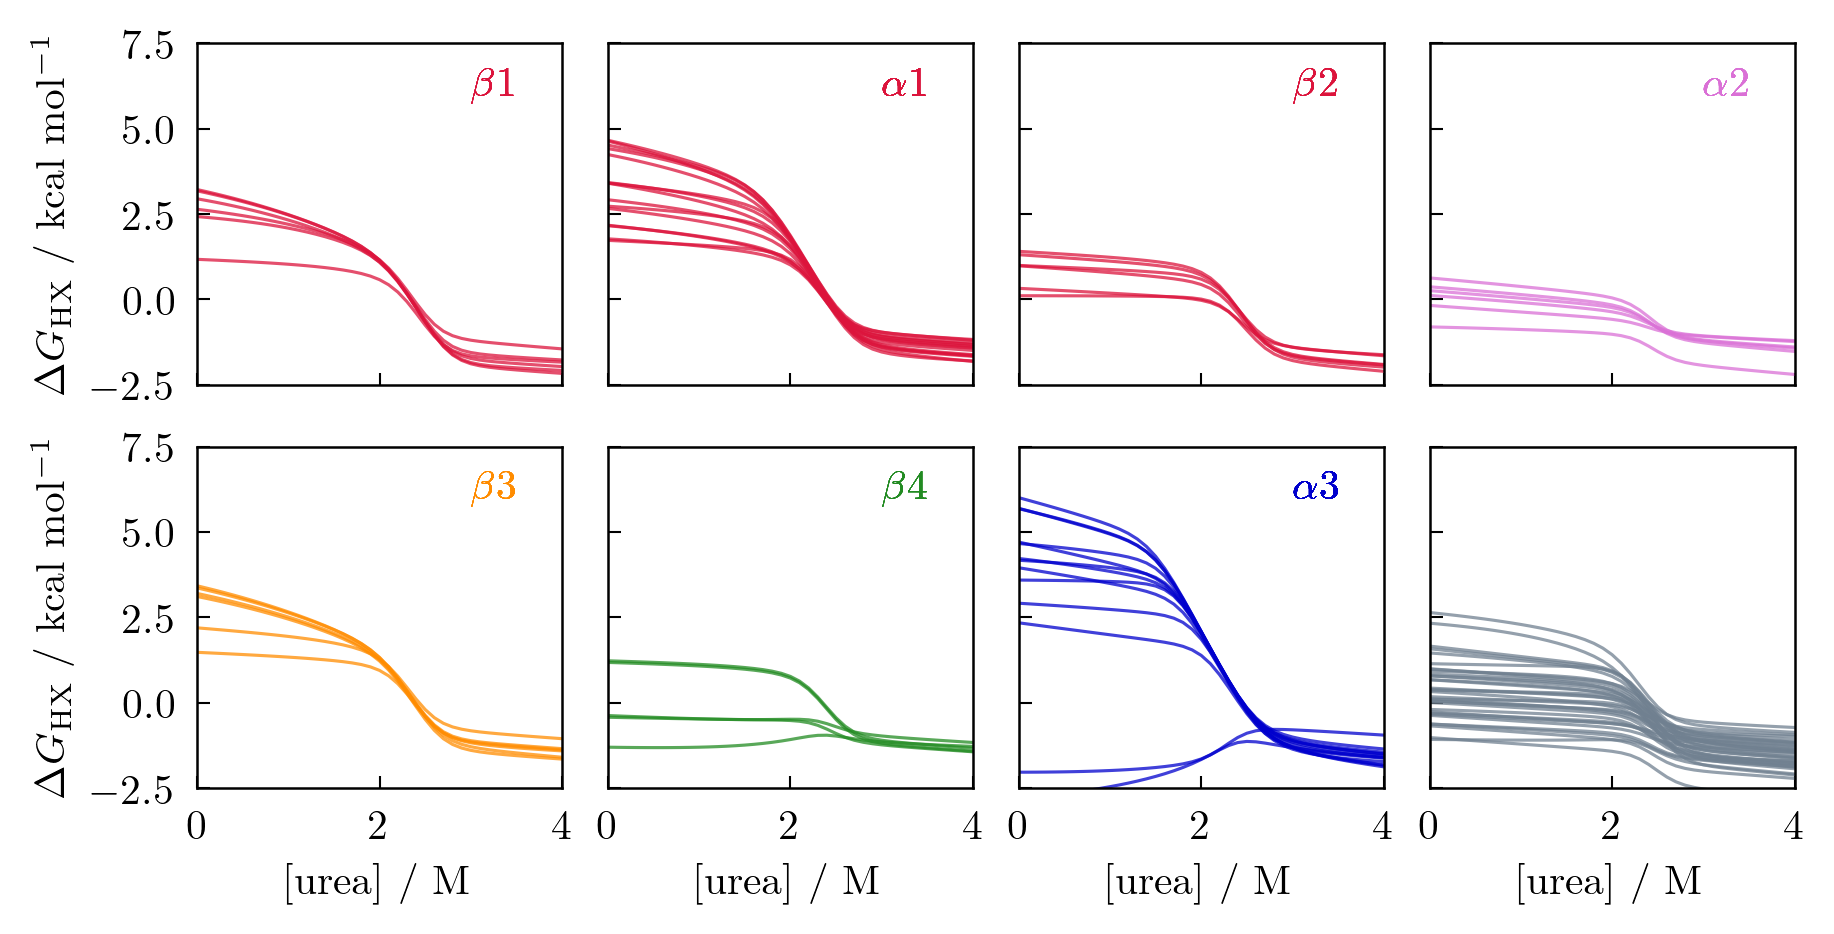

In [153]:
f, ax = plt.subplots(2, 4, figsize=(6,3), dpi=300, sharey=True, sharex=True, constrained_layout=True)

for i, (r, color) in enumerate(zip(res, color_arr[res])):
    if r >= 8 and r <= 13:
        j, k = 0, 0
        text = r'$\beta 1$'
    elif r >= 20 and r <= 34:
        j, k = 0, 1
        text = r'$\alpha 1$'
    elif r >= 40 and r <= 45:
        j, k = 0, 2
        text = r'$\beta 2$'
    elif r >= 49 and r <= 55:
        j, k = 0, 3
        text = r'$\alpha 2$'
    elif r >= 63 and r <= 68:
        j, k = 1, 0
        text = r'$\beta 3$'
    elif r >= 72 and r <= 76:
        j, k = 1, 1
        text = r'$\beta 4$'
    elif r >= 83 and r <= 95:
        j, k = 1, 2
        text = r'$\alpha 3$'
    else: 
        j, k = 1, 3
        text=''
    ax[j, k].plot(den, dGhx_D_all[T_id, msens_id, :, i], color=color, alpha=0.75)
    ax[j, k].text(3, 6, text, color=color)

ax[0,0].set_xlim([0, 4])
ax[0,0].set_ylim([-2.5, 7.5])
for a in ax.flat:
    a.set_xlabel('[urea] / M')
    a.set_ylabel('$\Delta G_{\mathrm{HX}}$ / kcal mol$^{-1}$')
    a.label_outer()

In [150]:
exp_and_sim_mVal

array([ 7,  8,  9, 10, 11, 12, 13, 15, 17, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 31, 32, 33, 35, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 58, 63,
       64, 65, 66, 67, 68, 73, 75, 83, 84, 85, 86, 88, 89, 90, 92, 93, 94])

Text(0.5, -0.2, '$r=0.20$\n RMSE = 0.34')

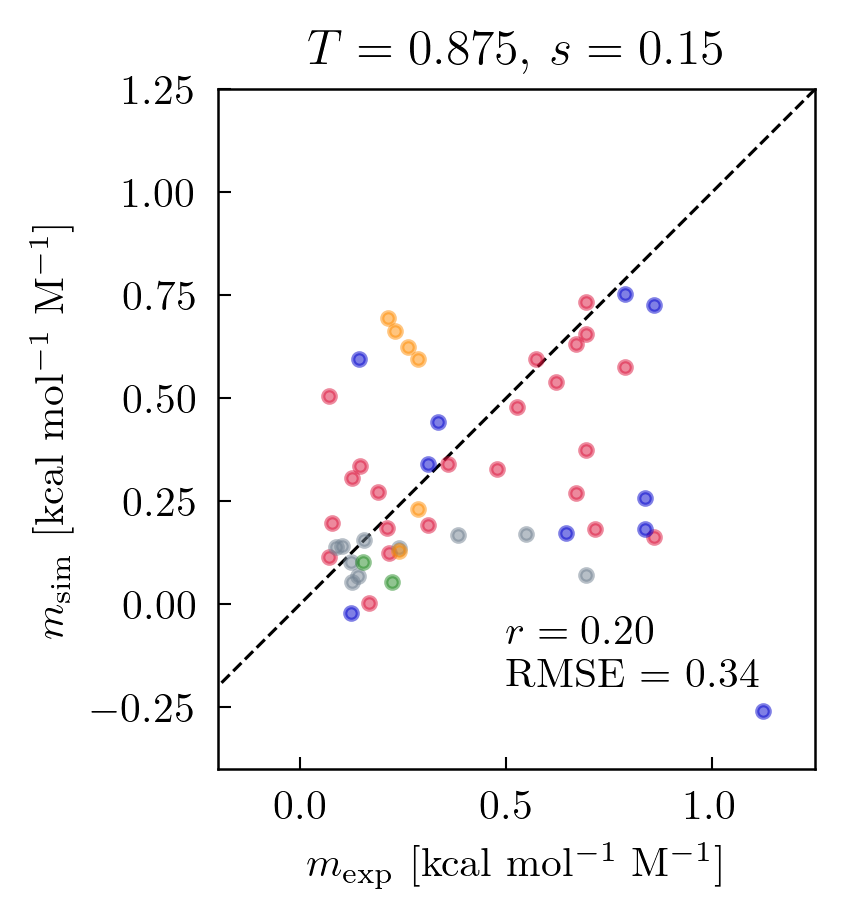

In [149]:
f, ax = plt.subplots(figsize=(3,3), dpi=300)

colors1 = color_arr[exp_and_sim_mVal]
alphas1 = alpha_arr[exp_and_sim_mVal]

for adg, dg, c, a, name in zip(
        mV_exp, mVs_sims[model_id], colors1, alphas1, names):
    ax.plot(adg, dg, '.', color=c, alpha=0.5, ms=6, mec=None)
    # ax.annotate(name, (adg, dg + 0.03), fontsize=6)
    
ax.set_xlabel('$m_{\mathrm{exp}}$ [kcal mol$^{-1}$ M$^{-1}$]')
ax.set_ylabel('$m_{\mathrm{sim}}$ [kcal mol$^{-1}$ M$^{-1}$]')
ax.set_xlim([-0.2, 1.25])
ax.set_ylim([-0.4, 1.25])
ax.set_aspect("equal")
ax.plot(np.linspace(-1, 1.5, 10), np.linspace(-1, 1.5, 10), 'k--', zorder=0)
ax.set_title(f'$T = {T_targets[T_id]:.3f}$, $s={m_senss[s_id]:.2f}$')
ax.annotate(f'$r={r1s[model_id][0]:.2f}$\n RMSE = {r1s[model_id][1]:.2f}', (0.5, -0.2))

Text(0.5, 1.0, '$T=0.85$, $s=0.15$')

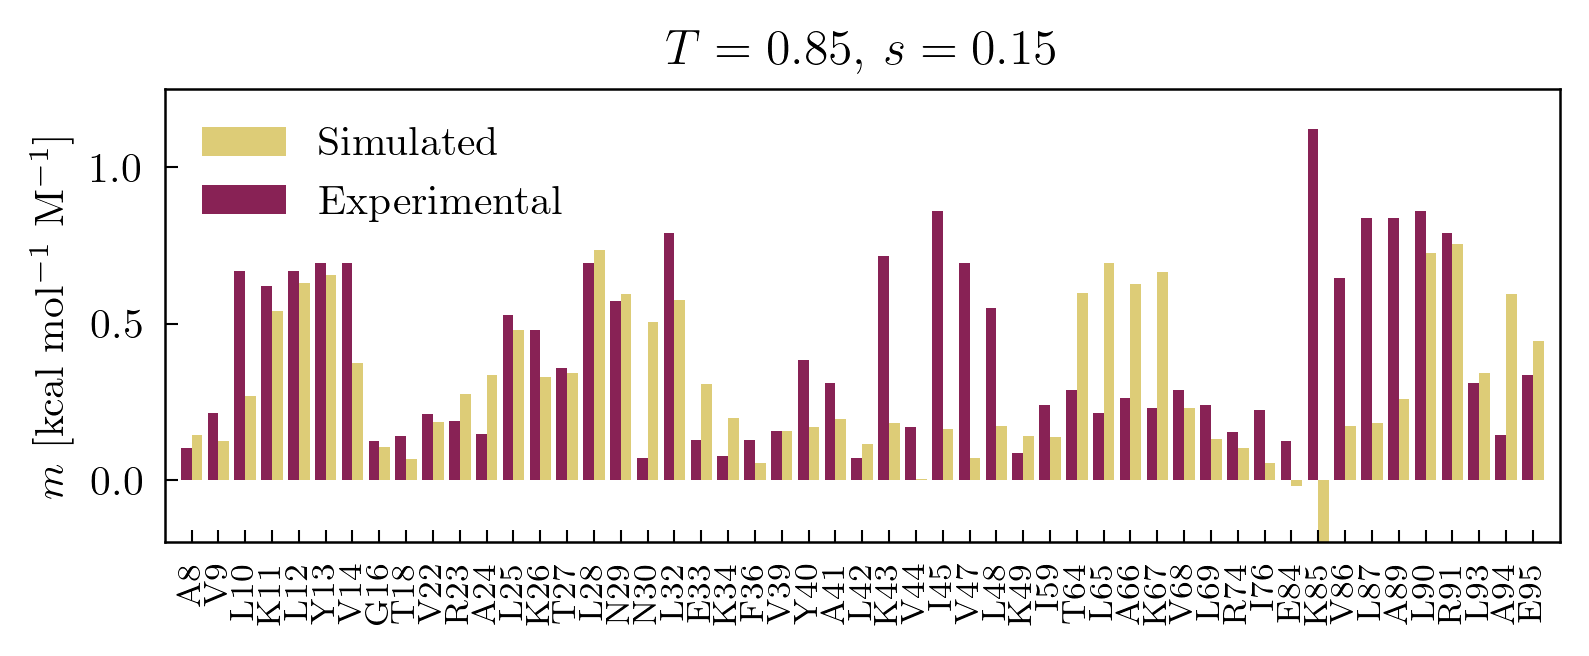

In [193]:
# plot residues
seq = "MAPLRKTAVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPAPVRRIIGDLSNREKVLIALRLLAEEIGD"
names = []
for r in exp_and_sim_dG:
    names.append(f"{seq[r]}{r + 1}")
T_ind = 15
n_data = len(exp_and_sim_dG)

fig = plt.figure(dpi=300, figsize=(6, 2))
ax = fig.gca()
plt.bar(range(n_data), mVs_sims[model_id], align='edge', width=0.4, label='Simulated', color='C2')
plt.bar(range(n_data), mV_exp, align='edge', width=-0.4, label='Experimental', color='C5')
plt.xlim([-1, n_data])
plt.ylim([-0.2, 1.25])
ax.set_ylabel('$m$ [kcal mol$^{-1}$ M$^{-1}$]')
ax.set_xticks(np.arange(n_data), names, rotation=90, fontsize=8)

pplt.legend(outside=False)
r2, pval = scipy.stats.pearsonr(exp_dGs[exp_and_sim_dG] / 4.184, dGhx_T[T_ind, sim_and_exp_dG])
plt.title(f"$T={Ts[T_ind, 0]:.2f}$, $s={m_senss[msens_id]}$")

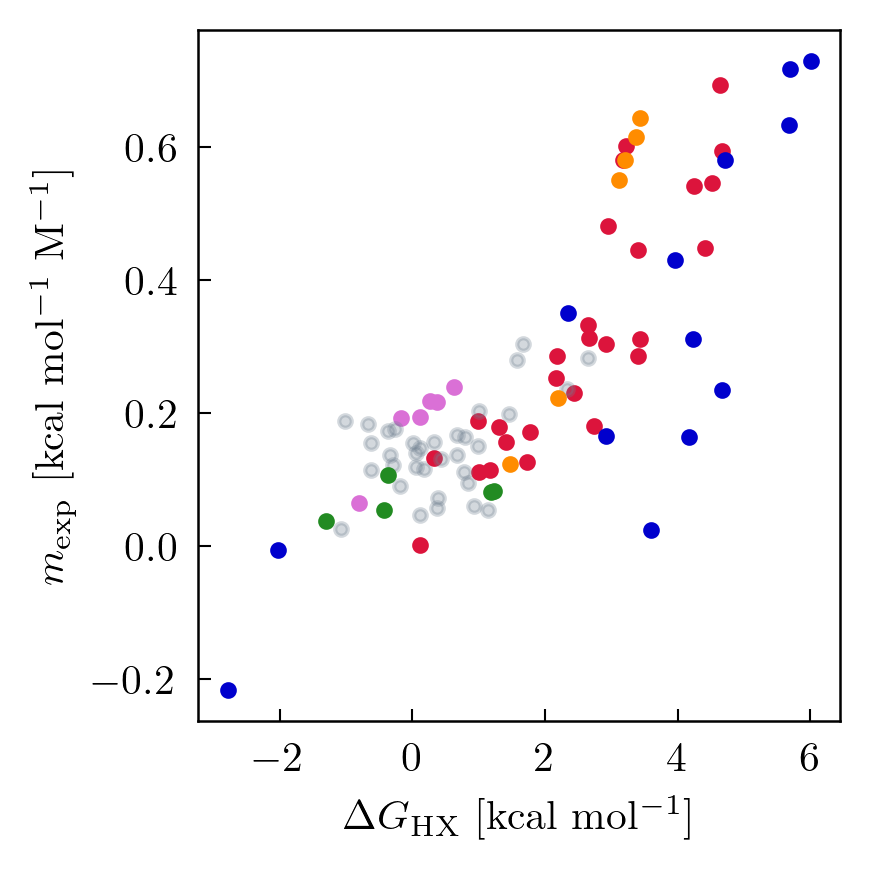

In [175]:
f1, ax1 = plt.subplots(figsize=(3,3), dpi=300)
for i, c in enumerate(color_arr[res]):
    if c == 'slategray':
        alpha = 0.3
    else:
        alpha = 1.0
    ax1.plot(dGhx_D_all[T_id, msens_id, 0, i], mValue_all[T_id, msens_id, 0, i], '.', color=c, alpha=alpha, markersize=6)
ax1.set_xlabel(r'$\Delta G_{\mathrm{HX}}$ [kcal mol$^{-1}$]')
ax1.set_ylabel(r'$m_{\mathrm{exp}}$ [kcal mol$^{-1}$ M$^{-1}$]')
f1.tight_layout()